In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir( os.path.join('..', 'notebook_format') )
from formats import load_style
load_style(css_style = 'custom2.css')

In [2]:
os.chdir(path)
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8, 6 # change default figure size
plt.rcParams['font.size'] = 12 # and font size

# 1. magic to print version
# 2. magic so that the notebook will reload external python modules
%load_ext watermark
%load_ext autoreload 
%autoreload 2

from tqdm import tqdm_notebook
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,scikit-learn,scipy,tqdm

Ethen 2016-12-16 11:56:31 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.2
pandas 0.18.1
matplotlib 1.5.1
scikit-learn 0.18
scipy 0.18.1


The dataset that we'll use is the [Online Retail Dataset](https://archive.ics.uci.edu/ml/datasets/Online+Retail) from the UCI Machine Learning repository and the raw data can be downloaded [here](https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx). As you can see in the description, this dataset contains all purchases made for an online retail company based in the UK during an eight month period (from 01/12/2010 to 09/12/2011).

We need to take all of the transactions for each customer and put these into a format that the algorithm can use. This means we need each unique customer ID in the rows of the matrix, each unique item ID in the columns of the matrix. And the values of the matrix should be the total number of purchases for each item by each customer

In [3]:
retail = pd.read_excel('Online Retail.xlsx')
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
print(retail.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


In [7]:
# drop the rows if the customer ID is missing 
data = retail[ ~pd.isnull(retail['CustomerID']) ]
data.shape

(406829, 8)

In [8]:
# convert to category to save memory
cat_cols = ['StockCode', 'Description', 'CustomerID', 'Country']
for col in cat_cols:
    data[col] = data[col].astype('category')

In [9]:
data[['StockCode', 'Description']].head()

,StockCode,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE METAL LANTERN
2,84406B,CREAM CUPID HEARTS COAT HANGER
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,RED WOOLLY HOTTIE WHITE HEART.


In [10]:
# item_lookup = cleaned_retail[['StockCode', 'Description']].drop_duplicates() # Only get unique item/description pairs
# item_lookup['StockCode'] = item_lookup.StockCode.astype(str) # Encode as strings for future lookup ease

In [11]:
grouped = ( data[['StockCode', 'Quantity', 'CustomerID']]
            .groupby(['CustomerID', 'StockCode'])
            .sum() )
grouped = grouped[ grouped['Quantity'] > 0 ].reset_index()
grouped.head()

,CustomerID,StockCode,Quantity
0,12347.0,16008,24.0
1,12347.0,17021,36.0
2,12347.0,20665,6.0
3,12347.0,20719,40.0
4,12347.0,20780,12.0


In [12]:
# map each artist and user to a unique numeric value
# convert StockCode, CustomerID to category to save memory
# and to assign a unique numeric value to each distinct category
# for constructing matrix
cat_cols = ['StockCode', 'CustomerID']
for col in cat_cols:
    grouped[col] = grouped[col].astype('category')

grouped.head()

,CustomerID,StockCode,Quantity
0,12347.0,16008,24.0
1,12347.0,17021,36.0
2,12347.0,20665,6.0
3,12347.0,20719,40.0
4,12347.0,20780,12.0


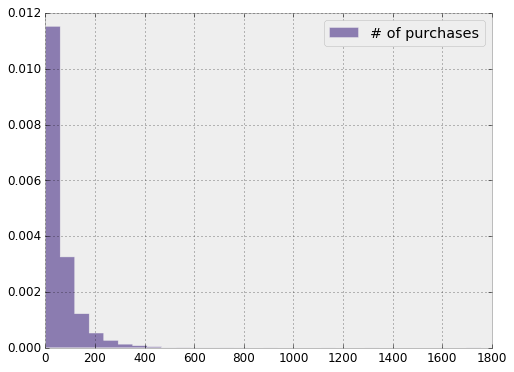

In [13]:
plt.hist( grouped['CustomerID'].value_counts(), 
          histtype = 'stepfilled', bins = 30, alpha = 0.85,
          label = '# of purchases', color = '#7A68A6', normed = True )
plt.legend(loc = "upper right")
plt.show()

In [215]:
# create a sparse matrix by passing in the 
# triplet (data, (row, column))
row = grouped['CustomerID'].cat.codes
col = grouped['StockCode'].cat.codes
preference = sp.csr_matrix(( grouped['Quantity'], (row, col) ))
preference

<4326x3649 sparse matrix of type '<class 'numpy.float64'>'
	with 265220 stored elements in Compressed Sparse Row format>

In [216]:
matrix_size = np.prod(preference.shape)
interaction = preference.nonzero()[0].shape[0]
sparsity = 100 * (1 - interaction / matrix_size)
sparsity

98.319858371954041

In [217]:
def create_train_test(preference, test_size, seed):
    # randomly chose user-item pairs that will be in the test
    nonzero_idx = preference.nonzero()
    interaction = nonzero_idx[0].shape[0]
    n_sample = int(interaction * test_size)
    np.random.seed(seed)
    test_idx = np.random.choice(n_sample, size = n_sample, replace = False)
    user = nonzero_idx[0][test_idx]
    item = nonzero_idx[1][test_idx]
    
    # assign all of the randomly chosen user-item pairs'
    # preference to the test and assign those pairs to zero
    # on the training (also get rid of those zeros to reduce storage) 
    train = preference.copy()
    test = sp.csr_matrix(preference.shape)
    test[user, item] = 1 #  # binary preference ?? train[user, item]
    train[user, item] = 0
    train.eliminate_zeros()
    return train, test, np.unique(user)

In [218]:
train, test, altered_user = create_train_test(
    preference = preference, 
    test_size = 0.2,
    seed = 1234
)
train

<4326x3649 sparse matrix of type '<class 'numpy.float64'>'
	with 212176 stored elements in Compressed Sparse Row format>

In [219]:
# test[test != 0] = 1
test

<4326x3649 sparse matrix of type '<class 'numpy.float64'>'
	with 53044 stored elements in Compressed Sparse Row format>

\begin{align} 
x_{u} = \big( Y^{T}Y + Y^{T}(C^{u}-I)Y + \lambda I \big)^{-1}Y^{T}C^{u}p(u)
\end{align}

In [49]:
class ImplicitMF:
    
    def __init__(self, n_iter, n_rank, alpha, reg, seed):
        self.reg = reg
        self.seed = seed
        self.alpha = alpha
        self.n_iter = n_iter
        self.n_rank = n_rank
    
    def fit(self, X):
        conf_mat = self.alpha * X
        self.n_user, self.n_item = conf.shape
        
        # initialize (user/item) latent vectors/matrix randomly with a set seed
        rstate = np.random.RandomState(seed)
        self.user_mat = sp.csr_matrix( rstate.normal( size = (self.n_user, self.n_rank) ) )
        self.item_mat = sp.csr_matrix( rstate.normal( size = (self.n_item, self.n_rank) ) )

        user_eye = sp.eye(self.n_user)
        item_eye = sp.eye(self.n_item)
        reg_eye  = self.reg * sp.eye(self.n_rank)       
        for _ in tqdm_notebook(range(self.n_iter), desc = 'training progress'):
            self.user_mat = self._als_step(conf_mat, self.user_mat, 
                                           self.item_mat, item_eye, reg_eye)
            self.item_mat = self._als_step(conf_mat.T, self.item_mat, 
                                           self.user_mat, user_eye, reg_eye)  
        return self
        
    def _als_step(self, conf_mat, solve_mat, fix_mat, fix_eye, reg_eye):
        # when solving the user/item matrix,
        # the other matrix will be fixed
        
        # prior to solving, compute the value independent
        # of each element of the matrix that will be solved;
        # this is the bottleneck and can be easily parallized
        # as each elements' computation is independent of one another
        fTf = fix_mat.T.dot(fix_mat)
        n_solve = solve_mat.shape[0]
        for n in range(n_solve):
            # use the dense vector to
            # create the binarized preference vector
            # and the diagonal confidence matrix C
            conf_dense = conf_mat[n].toarray()
            pref_vec = conf_dense.copy()
            pref_vec[pref_vec != 0] = 1
            pref_vec = sp.csr_matrix(pref_vec)

            # CI = C - I term
            # we should add 1 to each user index so every 
            # user-item is given minimal confidence, but
            # it cancels out with subtracting I
            CI = sp.diags(conf_dense, offsets = [0])

            # for the C term, we now have to add back I to
            # account for the minimal confidence
            fTCIf = fix_mat.T.dot(CI).dot(fix_mat)
            fTCIp = fix_mat.T.dot(CI + fix_eye).dot(pref_vec.T)
            solve_mat[n] = spsolve(fTf + fTCIf + reg_eye, fTCIp)        

        # ? don't need to return
        # and solve_mat is actually dense
        return solve_mat
    
    def predict(self):
        """predict ratings for every user and item"""
        pred = self.user_mat.dot(self.item_mat.T)
        return pred

In [50]:
# this takes a while (around 25 minutes)
als = ImplicitMF(n_iter = 50, n_rank = 20, alpha = 15, reg = 0.1, seed = 1234)
als.fit(train)

In [220]:
from implicit import alternating_least_squares
alpha = 15
user_vecs, item_vecs = alternating_least_squares( 
    Cui = (train * alpha).astype('double'),
    factors = 20,
    regularization = 0.1, 
    iterations = 50
)

In [221]:
from sklearn import metrics

def auc_score(y_true, y_pred):
    fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr) 
    return auc

In [222]:
def calc_mean_auc(training_set, altered_users, predictions, test_set):
    '''
    This function will calculate the mean AUC by user for any user that had their user-item matrix altered. 
    
    parameters:
    
    training_set - The training set resulting from make_train, where a certain percentage of the original
    user/item interactions are reset to zero to hide them from the model 
    
    predictions - The matrix of your predicted ratings for each user/item pair as output from the implicit MF.
    These should be stored in a list, with user vectors as item zero and item vectors as item one. 
    
    altered_users - The indices of the users where at least one user/item pair was altered from make_train function
    
    test_set - The test set constucted earlier from make_train function
    
    returns:
    
    The mean AUC (area under the Receiver Operator Characteristic curve) of the test set only on user-item interactions
    there were originally zero to test ranking ability in addition to the most popular items as a benchmark.
    '''
    
    store_auc = [] # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = [] # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1) # Get sum of item iteractions to find most popular
    item_vecs = predictions[1]
    for user in altered_users: # Iterate through each user that had an item altered
        training_row = training_set[user,:].toarray().reshape(-1) # Get the training set row
        zero_inds = np.where(training_row == 0) # Find where the interaction had not yet occurred
        # Get the predicted values based on our user/item vectors
        user_vec = predictions[0][user,:]
        
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[user,:].toarray()[0,zero_inds].reshape(-1) 
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
    # End users iteration
    
    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))  
   # Return the mean AUC rounded to three decimal places for both test and popularity benchmark

In [191]:
# training row
row = train[1000].toarray().ravel()
zero_inds = np.where(row == 0)
zero_inds

(array([   0,    1,    2, ..., 3646, 3647, 3648]),)

In [192]:
user_vec = user_vecs[1000]
pred = user_vec.dot(item_vecs.T)[zero_inds]
pred

array([ 0.30224276, -0.04336691,  0.21164836, ...,  0.48231236,
       -0.02847139, -0.16425949])

In [193]:
actual = test[1000, zero_inds].toarray().reshape(-1)
actual

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [194]:
auc_score(actual, pred)

nan

In [177]:
user_vec = user_vecs[1000]
pred = user_vec.dot(item_vecs.T)[0, zero_inds].toarray().ravel()
# pred = user_vec.dot(als.item_mat.T).toarray().ravel()[zero_inds]
pred

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

In [163]:
test = auc_score(actual, pred)
np.mean([ test, 1])

nan

In [ ]:
auc_score(pop, actual)

In [137]:
# get the number of users that have purchased each item
# to find the most popular item
pop_item = np.array( test.sum(axis = 0) ).ravel()
pop = pop_item[zero_inds]
pop

array([  16.,    1.,    3., ...,   29.,    0.,  293.])

(3629,)

In [77]:
store_auc = []
popularity_auc = []
test

<4326x3649 sparse matrix of type '<class 'numpy.float64'>'
	with 53044 stored elements in Compressed Sparse Row format>

In [223]:
calc_mean_auc(train, altered_user, 
              [sp.csr_matrix(user_vecs), sp.csr_matrix(item_vecs.T)], test)

ValueError: Data is not binary and pos_label is not specified

In [208]:
x = np.arange(3)
x.T.dot(x)

5

In [210]:
np.outer(x, x)

array([[0, 0, 0],
       [0, 1, 2],
       [0, 2, 4]])

In [211]:
seed = 1234
alpha = 40
n_rank = 20
reg = 0.1
conf = alpha * train
n_user, n_item = conf.shape

# initialize our X/Y (user/item) vectors randomly with a set seed
rstate = np.random.RandomState(seed)
X = sp.csr_matrix( rstate.normal( size = (n_user, n_rank) ) )
Y = sp.csr_matrix( rstate.normal( size = (n_item, n_rank) ) )

X_eye = sp.eye(n_user)
Y_eye = sp.eye(n_item)
lambda_eye = reg * sp.eye(n_rank)
lambda_eye.shape

(20, 20)

In [212]:
lambda_eye

<20x20 sparse matrix of type '<class 'numpy.float64'>'
	with 20 stored elements (1 diagonals) in DIAgonal format>

In [205]:
YTY = Y.T.dot(Y)
XTX = X.T.dot(X)

In [213]:
for u in range(1):
    # create binarized preference vector
    # conf_dense = conf[u].copy()
    # nonzero_idx = conf_dense.nonzero()[1]
    # conf_dense[:, nonzero_idx] = 1
    conf_dense = conf[u].toarray()
    pu = conf_dense.copy()
    pu[pu != 0] = 1
    # pu = sp.csr_matrix(pu)
    print(pu.shape)

    # CuI = Cu - I term, n_item * n_item
    # we should add 1 to each user index so every 
    # user-item is given minimal confidence, but
    # it cancels out with subtracting I
    CuI = sp.diags(conf_dense, offsets = [0])
    print(CuI.shape)
    # for Cu we now have to add back I to
    # account for the minimal confidence
    YTCuIY = Y.T.dot(CuI).dot(Y)
    testing = Y.T.dot(CuI + Y_eye)
    print(testing.shape)
    print(pu.T.shape)
    YTCupu = Y.T.dot(CuI + Y_eye).dot(pu.T)
    A = YTY + YTCuIY + lambda_eye
    X[u] = spsolve(YTY + YTCuIY + lambda_eye, YTCupu)

(1, 3649)
(3649, 3649)
(20, 3649)
(3649, 1)


In [207]:
pu

<1x3649 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [41]:
for i in range(n_item):
    conf_dense = conf.T[i].toarray()
    pu = conf_dense.copy()
    pu[pu != 0] = 1
    pu = sp.csr_matrix(pu)

    CiI = sp.diags(conf_dense, offsets = [0])
    XTCiIX = X.T.dot(CiI).dot(X)
    xTCiPi = X.T.dot(CiI + X_eye).dot(pu.T)
    Y[i] = spsolve(XTX + XTCiIX + lambda_eye, xTCiPi)

Y

<3649x20 sparse matrix of type '<class 'numpy.float64'>'
	with 72980 stored elements in Compressed Sparse Row format>

In [ ]:
user_vecs, item_vecs = implicit_weighted_ALS(
    product_train, 
    lambda_val = 0.1, 
    alpha = 15, 
    iterations = 1,
    rank_size = 20
)